# CS 330 Autumn 2019/2020 Homework 3

## Goal Conditioned Reinforcement Learning and Hindsight Experience Replay

Due Wednesday November 6th, 11:59 PM PST

SUNet ID:
Name:
Collaborators:

By turning in this assignment, I agree by the Stanford honor code and declare that all of
this is my own work.

# Overview

In this assignment we will be looking at goal-conditioned learning and hindsight experience
replay (HER). In particular, you will:

1. Adapt an existing model (a Deep Q-Network) to be goal-conditioned.
2. Run goal-conditioned DQN on two environments
3. Implement Hindsight Experience Replay (HER) [1,2] on top of a goal-conditioned DQN
for each environment
4. Compare the performance with and without HER

**Submission**: To submit your homework, submit one pdf report and one zip file to Gradescope, where the report will contain answers to the deliverables listed below and the zip file contains your code bits_main.py and sawyer_main.py with the filled in solutions.

## Code Overview:

The code consists of four files. You should only make modifications to
two of them.

* `BitFlip.py`: Bit flipping environment for problems 1-3. You should not modify this
file, though it may be helpful to look at it and understand the environment.


* `buffers.py`: Buffers for storing experiences. You should not modify this file, though
it may be useful to look it.


* `bits_main.py`: Main loop and helper functions for solving the bit flipping environment.
You will add your solutions to problems 1 and 2 to this file and run it for problem 3.

* `sawyer_main.py`: Main loop and helper functions for solving the Sawyer arm environment. You will add your solutions to problem 4 to this file and run it for problem 5.


## Dependencies:

We expect code in Python 3.5+ with Pillow, scipy, numpy, tensorflow,
gym, mujoco, multiworld installed.

> `pip install pillow, scipy, numpy, gym, mujoco, multiworld, tensorflow`


In [9]:
#!pip install pillow, scipy, numpy, gym, mujoco, multiworld, tensorflow

In [10]:
# Widescreen notebook
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Environments

You will be running on two environments:

## Environment 1: Bit Flipping Environment

In the bit-flipping environment, **the state is a binary vector with length n**.

The **goal** is **to reach a known goal vector**, which is also a binary vector with length n.

At each step, **we can flip a single value** in the vector (changing a 0 to 1 or a 1 to 0).

This environment can very easily be solved without reinforcement learning, but we will use a DQN to demonstrate how adding HER can improve performance.

![asd](../img/hw3-flip-env.png)
\* Diagram: 4 bit environment

The bit flipping environment is an example of an environment with **sparse rewards**.

At each step, **we receive a reward of -1 when the goal and state vector do not match and a reward
of 0 when they do**.

As the **size of the vector grows**, we receive **fewer and fewer non-negative rewards**.

**Adding HER helps us train in an environment with sparse rewards** (more details later).

The bit flipping environment is included in the homework zip file as `BitFlip.py` and does
not require additional installation.

## Environment 2: 2D Sawyer Arm

The Sawyer Arm is a multi-jointed robotic arm for grasping and reaching (https://robots.ieee.org/robots/sawyer/).

The arm operates in a 2D space, and the **goal is to move the robot to a set of coordinates (x, y)**.

To run the Sawyer Arm environment, you will have to install several packages.

If you have any trouble with installation, please post on Piazza; it’s likely that other students have
run into the same problem.

### Installing gym

Gym is a package for comparing reinforcement learning algorithms.

It is a widely used library, and contains several simulated tasks for testing algorithms such as teaching robots to walk and balancing a pole on a cart. Instructions for installing gym are here http://gym.openai.com/docs/.

Run:

    pip install gym

### Installing Mujoco

Mujoco is a physics simulation engine that runs with gym. You will be emailed a class license for Mujoco.

DO NOT REDISTRIBUTE THE LICENSE KEY.

#### Instructions

for installing Mujoco can be found here: https://github.com/openai/mujoco-py.

Run:

    pip install mujoco-py

### Installing multiworld
    
To install multiworld, run

    git clone https://github.com/vitchyr/multiworld
    
navigate to the setup.py and run
    
    python setup.py install

# Problem 1: Implementing Goal-Conditioned RL on Bit Flipping

The file `bits_main.py` contains a DQN that runs in a bit-flipping environment.

Currently the DQN is **not goal-conditioned** and does **not have HER implemented**.

The Q-function takes in **only the state as the input**, and does not consider the goal.

To modify the Q-function to be goal-conditioned, **concatenate the observation vector with the goal vector and pass the combined vector to the Q-function**.

You can think of the goal-conditioned implementation as an **extended Markov decision process (MDP)**, where your **state space contains both the original state and the goal**.

a) Run `bits_main.py` with the following arguments:

    python bits_main.py --num_bits=7 --num_epochs=150
    
**Save the generated plot** and include it in your homework.

This plot illustrates the performance without goal conditioning.

b) **Modify the DQN** so that it is **goal-conditioned**.

The places where you will need to make modifications are marked in `bits_main.py`.

You should **not** make modifications to `buffers.py` or `BitFlip.py`.

*Hint:* the bit flipping environment returns the state and goal vector when reset() is called.

---

a) *Dont forget to run a) and save the plot, you'll modify that code in a bit*

    python bits_main.py --num_bits=7 --num_epochs=150
    

b) Particularly, we need to modify TWO sections of the code:

1. Input to the NN model
2. Solve environment loop

> Why do you think we need to modify the input to the neural network model as we modify DQN to be **goal-conditioned**?
>
> > ```python
> > # ======================== TODO modify code ========================
> > 
> > self.inp = tf.placeholder(shape = [None, num_bits],dtype = tf.float32)
> > 
> > # ========================      END TODO       ========================
> > net = self.inp
> > net = slim.fully_connected(net,hidden_dim,activation_fn = tf.nn.relu)
> > ...
> > ```
>
> What about the loop over each episode? what do we need to change there?
>
> > ```python
> > for t in range(num_bits):
> >     # attempt to solve the state - number of steps given to solve the
> >     # state is equal to the size of the vector
> >     
> >     # ======================== TODO modify code ========================
> > 
> >     inp_state = state
> >     # forward pass to find action
> >     action = sess.run(model.predict,feed_dict = {model.inp : [inp_state]})[0]
> >     # take the action
> >     next_state,reward,done, _ = bit_env.step(action)
> >     # add to the episode experience (what happened)
> >      episode_experience.append((state, action, reward, next_state, goal_state))
> >     # calculate total reward
> >     total_reward+=reward
> >     # update state
> >     state = next_state
> >     # mark that we've finished the episode and succeeded with training
> >     if done:
> >         if succeeded:
> >             continue
> >         else:
> >             succeeded = True
> >     
> >     # ========================      END TODO       ========================
> > ```

### Recall:

Adding a goal to our framework changes two things:

1. **States now also include the goal state** :

  ```python
   state = [observation, goal_state]
   ```
    
   which in our case those are vectors of n bits/digits
   
   ```python
   observation = [0 0 0 1]
   goal_state  = [0 1 0 1]

   state = [0 0 0 1 0 1 0 1]
   ```

2. **Rewards are replaced by a distance metric between observation and goal state**
   
   Before we had:
   
   ```python
   next_state, reward, done, _ = bit_env.step(action)
   ```
    
   and we want to replace that reward for a distance to a given goal:
   
   ```python
   # Sparse
   # -1 if not equal; 0 if equal
   # -dirac{ state != goal_state }
   reward = -1 if (next_state != goal_state)

   # L2 norm (squared): ||different bits||^2
   reward = -1 * np.sum(np.power( (next_state - goal_state), 2) )
    ```
   

We want to add goal conditioning to our DQN, but without changing the environment, so we need to modify **EACH** state as is observed to include, also, the goal state:

> ```python
> inp_state = np.concatenate(state, goal_state)
> ```

Each `state` now (and also `next state`s) will need to have the observed state as a vector concatenated with the goal state vector.



In [13]:
from tqdm import tqdm


# Code and Experiments

In [1]:
import numpy as np
import tensorflow as tf
# import tensorflow.contrib.slim as slim
import tf_slim as slim
from BitFlip import BitFlipEnv
from buffers import Buffer
from matplotlib import pyplot as plt
from tqdm import tqdm


tf.reset_default_graph()

flags = tf.app.flags

flags.DEFINE_string("HER", "None",
                    "different strategies of choosing goal. Possible values are :- future, final, episode or None. If None HER is not used")
flags.DEFINE_integer("num_bits", 15, "number of bits in the bit-flipping environment")
flags.DEFINE_integer("num_epochs", 250, "Number of epochs to run training for")
flags.DEFINE_integer("log_interval", 5, "Epochs between printing log info")
flags.DEFINE_integer("opt_steps", 40, "Optimization steps in each epoch")

FLAGS = flags.FLAGS

In [2]:
class Model:
    '''Define Q-model'''

    def __init__(self, num_bits, scope, reuse):
        # initialize model
        hidden_dim = 256
        with tf.variable_scope(scope, reuse=reuse):
            # ======================== TODO modify code ========================
            # J: Goal conditioning brings two distinctions:
            #    1. state has attached goal_state
            #    2. reward is some distance to goal_state from current state
            # Before goal conditioning:
            #self.inp = tf.placeholder(shape=[None, num_bits], dtype=tf.float32)
            self.inp = tf.placeholder(shape=[None, 2 * num_bits], dtype=tf.float32)

            # ========================      END TODO       ========================
            net = self.inp
            net = slim.fully_connected(net, hidden_dim, activation_fn=tf.nn.relu)
            self.out = slim.fully_connected(net, num_bits, activation_fn=None)
            self.predict = tf.argmax(self.out, axis=1)
            self.action_taken = tf.placeholder(shape=[None], dtype=tf.int32)
            action_one_hot = tf.one_hot(self.action_taken, num_bits)
            Q_val = tf.reduce_sum(self.out * action_one_hot, axis=1)
            self.Q_target = tf.placeholder(shape=[None], dtype=tf.float32)
            self.loss = tf.reduce_mean(tf.square(Q_val - self.Q_target))
            self.train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.loss)


def update_target_graph(from_scope, to_scope, tau):
    '''update the target network by copying over the weights from the policy
    network to the target network'''
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)
    ops = []
    for (var1, var2) in zip(from_vars, to_vars):
        ops.append(var2.assign(var2 * tau + (1 - tau) * var1))

    return ops


def updateTarget(ops, sess):
    for op in ops:
        sess.run(op)

In [3]:
# ************   Define global variables and initialize    ************ #

num_bits = 7  # number of bits in the bit_flipping environment
# 
tau = 0.95  # Polyak averaging parameter
buffer_size = 1e6  # maximum number of elements in the replay buffer
batch_size = 128  # number of samples to draw from the replay_buffer

num_epochs = 150#FLAGS.num_epochs  # epochs to run training for
num_episodes = 16  # episodes to run in the environment per epoch
num_relabeled = 4  # relabeled experiences to add to replay_buffer each pass
gamma = 0.98  # weighting past and future rewards




In [4]:
def solve_environment(state, goal_state, total_reward, sess, model, bit_env, num_bits):
    '''attempt to solve the bit flipping environment using the current policy'''

    # list for recording what happened in the episode
    episode_experience = []
    succeeded = False

    for t in range(num_bits):
        # attempt to solve the state - number of steps given to solve the
        # state is equal to the size of the vector
        # ======================== TODO modify code ========================
        #print(t, state, goal_state)
        inp_state = state
        # J: Concat goal_state to each state observation
        inp_state = np.concatenate([state, goal_state])
        
        #print(t, inp_state, num_bits)
        # forward pass to find action
        
        action = sess.run(model.predict, feed_dict={model.inp: [inp_state]})[0]
        # take the action
        next_state, reward, done, _ = bit_env.step(action)
        # J: In Goal cond. RL, reward=-distance(state, goal)
        r_func = 'l2'
        if r_func == 'sparse':
            # -1 if not equal; 0 if equal
            # -dirac{ state != goal_state }
            reward = -1 * np.any(next_state != goal_state)
        elif r_func == 'l2':
            # L2 norm (squared): ||different bits||^2
            reward = -1 * np.sum(np.power( (next_state - goal_state), 2) )

        # J: Update state and next_state with goal_state (to sample from batch of experience later)
        state_g = np.asarray([state, goal_state]).flatten()
        next_state_g = np.asarray([next_state, goal_state]).flatten()
        # add to the episode experience (what happened)
        episode_experience.append((state_g, action, reward, next_state_g, goal_state))
        # calculate total reward
        total_reward += reward
        # update state
        state = next_state
        # mark that we've finished the episode and succeeded with training
        if done:
            if succeeded:
                continue
            else:
                succeeded = True

        # ========================      END TODO       ========================

    return succeeded, episode_experience, total_reward / 5


def update_replay_buffer(self, episode_experience, HER):
    '''adds past experience to the replay buffer. Training is done with episodes from the replay
    buffer. When HER is used, relabeled experiences are also added to the replay buffer

    inputs: epsidode_experience - list of transitions from the last episode
    modifies: replay_buffer
    outputs: None'''

    for t in range(num_bits):
        # copy actual experience from episode_experience to replay_buffer

        # ======================== TODO modify code ========================
        s, a, r, s_, g = episode_experience[t]
        m = len(s) // 2
        # state
        inputs = s
        # next state
        inputs_ = s_
        # add to the replay buffer
        self.replay_buffer.add(inputs, a, r, inputs_)

        # when HER is used, each call to update_replay_buffer should add num_relabeled
        # relabeled points to the replay buffer

        if HER == 'None':
            # HER not being used, so do nothing
            pass

        elif HER == 'final':
            # final - relabel based on final state in episode
            # pass
            _, _, _, final_state, g_ = episode_experience[-1]
            new_goal = final_state[:m]
            # Update next_state as [next_state, new_goal_state]
            relabel_state = np.asarray([s_[:m], new_goal]).flatten()
            # Update reward (distance)
            r_new = -1 * np.sum(np.power((s_[:m] - new_goal), 2))
            self.replay_buffer.add(inputs, a, r_new, relabel_state)

        elif HER == 'future':
            # future - relabel based on future state. At each timestep t, relabel the
            # goal with a randomly select timestep between t and the end of the
            # episode
            # pass
            t_future = np.random.randint(t, m)
            _, _, _, relabel_goal, _ = episode_experience[t_future]
            self.replay_buffer.add(inputs, a, r, relabel_goal)


        elif HER == 'random':
            # random - relabel based on a random state in the episode
            #pass
            m = len(episode_experience)
            t_random = np.random.randint(0, m)
            _, _, _, relabel_goal, _ = episode_experience[t_random]
            self.replay_buffer.add(inputs, a, r, relabel_goal)

        # ========================      END TODO       ========================

        else:
            print("Invalid value for Her flag - HER not used")
    return

In [5]:
def plot_success_rate(success_rates, labels):
    '''This function plots the success rate as a function of the number of cycles.
    The results are averaged over num_epochs epochs.

    inputs: success_rates - list with each element a list of success rates for
                            a epochs of running flip_bits
            labels - list of labels for each success_rate line'''

    for i in range(len(success_rates)):
        plt.plot(success_rates[i], label=labels[i])

    plt.xlabel('Epochs')
    plt.ylabel('Success rate')
    plt.title('Success rate with %d bits' % num_bits)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

    return

In [23]:
# ************   Main training loop    ************ #

def flip_bits(self,
              HER="final", 
              num_bits=7, 
              num_epochs=150,
              log_interval=5,
              opt_steps=40,
              num_episodes=16):
    '''Main loop for running in the bit flipping environment. The DQN is
    trained over num_epochs. In each epoch, the agent runs in the environment
    num_episodes number of times. The Q-target and Q-policy networks are
    updated at the end of each epoch. Within one episode, Q-policy attempts
    to solve the environment and is limited to the same number as steps as the
    size of the environment

    inputs: HER - string specifying whether to use HER'''

    print("Running bit flip environment with %d bits and HER policy: %s" % (num_bits, HER))
    
    
    # create bit flipping environment and replay buffer
#     bit_env = BitFlipEnv(num_bits)
#     replay_buffer = Buffer(buffer_size, batch_size)

#     # set up Q-policy (model) and Q-target (target_model)
#     model = Model(num_bits, scope='model', reuse=True)
#     target_model = Model(num_bits, scope='target_model', reuse=True)

#     update_ops_initial = update_target_graph('model', 'target_model', tau=0.0)
#     update_ops = update_target_graph('model', 'target_model', tau=tau)

#     sess = tf.InteractiveSession()
#     sess.run(tf.global_variables_initializer())

#     # start by making Q-target and Q-policy the same
#     updateTarget(update_ops_initial, sess)
    

#     total_loss = []  # training loss for each epoch
#     success_rate = []  # success rate for each epoch
    # Shorter names for clarity later on
    model = self.model
    target_model = self.target_model 
    
    bit_env = self.bit_env
    sess = self.sess
    
    replay_buffer = self.replay_buffer
    update_replay_buffer = self.update_replay_buffer
    
    update_ops = self.update_ops 
    update_ops_initial = self.update_ops_initial 
    
    success_rate = []
    total_loss = []
    

    for i in trange(num_epochs):
        # Run for a fixed number of epochs

        total_reward = 0.0  # total reward for the epoch
        successes = []  # record success rate for each episode of the epoch
        losses = []  # loss at the end of each epoch

        for k in range(num_episodes):
            # Run in the environment for num_episodes  

            state, goal_state = bit_env.reset()  # reset the environment
            # attempt to solve the environment
            succeeded, episode_experience, total_reward = solve_environment(state, goal_state, total_reward,
                                                                            sess, model, bit_env, num_bits)
            successes.append(succeeded)  # track whether we succeeded in environment
            update_replay_buffer(episode_experience, HER)  # add to the replay buffer; use specified  HER policy

        for k in range(opt_steps):
            # optimize the Q-policy network

            # sample from the replay buffer
            state, action, reward, next_state = replay_buffer.sample()
            # forward pass through target network
            target_net_Q = sess.run(target_model.out, feed_dict={target_model.inp: next_state})
            # calculate target reward
            target_reward = np.clip(np.reshape(reward, [-1]) + gamma * np.reshape(np.max(target_net_Q, axis=-1), [-1]),
                                    -1. / (1 - gamma), 0)
            # calculate loss
            _, loss = sess.run([model.train_step, model.loss],
                               feed_dict={model.inp: state, model.action_taken: np.reshape(action, [-1]),
                                          model.Q_target: target_reward})
            # append loss from this optimization step to the list of losses
            losses.append(loss)

        updateTarget(update_ops, sess)  # update target model by copying Q-policy to Q-target
        success_rate.append(np.mean(successes))  # append mean success rate for this epoch
        total_loss.append(np.mean(losses)) # J: Added; mean training loss for each epoch
        
        if i % log_interval == 0:
            print('Epoch: %d  Mean reward: %f  Success rate: %.4f Mean loss: %.4f' % (
                i, total_reward, np.mean(successes), np.mean(losses)))

    return success_rate

In [24]:
import tensorflow.keras as keras

In [25]:
tf.reset_default_graph()

In [29]:
from tqdm import trange

In [30]:
class experiment:
    def __init__(self,HER="final", 
                      num_bits=7, 
                      num_epochs=250,
                      log_interval=25,
                      opt_steps=40,
                      num_episodes=64):
        
        self.HER=HER
        self.num_bits=num_bits
        self.num_epochs=num_epochs
        self.log_interval=log_interval
        self.opt_steps=opt_steps
        self.num_episodes=num_episodes
        
        # set up Q-policy (model) and Q-target (target_model)
        self.set_up_networks()

        self.total_loss = []  # training loss for each epoch
        self.success_rate = []  # success rate for each epoch
    
    def set_up_networks(self):
        # set up Q-policy (model) and Q-target (target_model)
        tf.reset_default_graph()
        tf.keras.backend.clear_session()
        # create bit flipping environment and replay buffer
        self.bit_env = BitFlipEnv(self.num_bits)
        self.replay_buffer = Buffer(buffer_size, batch_size)
        
        # set up Q-policy (model) and Q-target (target_model)
        #self.set_up_networks()
        self.model = Model(self.num_bits, scope='model', reuse=False)
        self.target_model = Model(self.num_bits, scope='target_model', reuse=False)

        self.update_ops_initial = update_target_graph('model', 'target_model', tau=0.0)
        self.update_ops = update_target_graph('model', 'target_model', tau=tau)

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

        # start by making Q-target and Q-policy the same
        updateTarget(self.update_ops_initial, self.sess)
    
    def run_games(self, n=1):
        successes = []
        for i in range(n):#tqdm(range(n)):
            #self.set_up_networks()

            successes.append(flip_bits(self,
                                      HER=self.HER, 
                                      num_bits=self.num_bits, 
                                      num_epochs=self.num_epochs,
                                      log_interval=self.log_interval,
                                      opt_steps=self.opt_steps,
                                      num_episodes=self.num_episodes))
            #self.sess.close()
            #tf.reset_default_graph()
            self.set_up_networks()
            
        return (successes)
        
    def update_replay_buffer(self, episode_experience, HER):
        update_replay_buffer(self, episode_experience, HER)
        

In [31]:
x = experiment()

In [35]:
x.log_interval = 10

In [36]:
results = x.run_games(n=1)

  0%|          | 0/250 [00:00<?, ?it/s]

Running bit flip environment with 7 bits and HER policy: final


  0%|          | 1/250 [00:00<01:08,  3.65it/s]

Epoch: 0  Mean reward: -2.748652  Success rate: 0.4531 Mean loss: 2.9265


  4%|▍         | 11/250 [00:02<00:55,  4.29it/s]

Epoch: 10  Mean reward: -2.958071  Success rate: 0.3594 Mean loss: 2.9386


  8%|▊         | 21/250 [00:04<00:52,  4.37it/s]

Epoch: 20  Mean reward: -2.876043  Success rate: 0.5938 Mean loss: 2.9935


 12%|█▏        | 31/250 [00:07<00:50,  4.33it/s]

Epoch: 30  Mean reward: -1.103559  Success rate: 0.5312 Mean loss: 2.9108


 16%|█▋        | 41/250 [00:09<00:47,  4.36it/s]

Epoch: 40  Mean reward: -2.087672  Success rate: 0.6562 Mean loss: 2.8684


 20%|██        | 51/250 [00:11<00:45,  4.34it/s]

Epoch: 50  Mean reward: -2.501192  Success rate: 0.7031 Mean loss: 2.8114


 24%|██▍       | 61/250 [00:14<00:44,  4.21it/s]

Epoch: 60  Mean reward: -3.604990  Success rate: 0.8594 Mean loss: 2.6184


 28%|██▊       | 71/250 [00:16<00:43,  4.09it/s]

Epoch: 70  Mean reward: -2.023027  Success rate: 1.0000 Mean loss: 2.6573


 32%|███▏      | 81/250 [00:19<00:43,  3.86it/s]

Epoch: 80  Mean reward: -1.148559  Success rate: 0.9844 Mean loss: 2.5902


 36%|███▋      | 91/250 [00:21<00:39,  4.06it/s]

Epoch: 90  Mean reward: -3.563930  Success rate: 1.0000 Mean loss: 2.6015


 40%|████      | 101/250 [00:23<00:36,  4.08it/s]

Epoch: 100  Mean reward: -1.065150  Success rate: 1.0000 Mean loss: 2.3703


 44%|████▍     | 111/250 [00:26<00:35,  3.94it/s]

Epoch: 110  Mean reward: -1.879681  Success rate: 1.0000 Mean loss: 2.3284


 48%|████▊     | 121/250 [00:29<00:34,  3.70it/s]

Epoch: 120  Mean reward: -2.370778  Success rate: 1.0000 Mean loss: 2.2728


 52%|█████▏    | 131/250 [00:32<00:35,  3.39it/s]

Epoch: 130  Mean reward: -2.068291  Success rate: 1.0000 Mean loss: 2.1352


 56%|█████▋    | 141/250 [00:34<00:31,  3.43it/s]

Epoch: 140  Mean reward: -1.274600  Success rate: 1.0000 Mean loss: 2.2475


 60%|██████    | 151/250 [00:37<00:26,  3.71it/s]

Epoch: 150  Mean reward: -2.454343  Success rate: 1.0000 Mean loss: 2.2582


 64%|██████▍   | 161/250 [00:40<00:24,  3.56it/s]

Epoch: 160  Mean reward: -2.115935  Success rate: 1.0000 Mean loss: 2.0879


 68%|██████▊   | 171/250 [00:43<00:21,  3.67it/s]

Epoch: 170  Mean reward: -2.119853  Success rate: 1.0000 Mean loss: 2.1366


 72%|███████▏  | 181/250 [00:46<00:19,  3.51it/s]

Epoch: 180  Mean reward: -3.089492  Success rate: 1.0000 Mean loss: 2.0523


 76%|███████▋  | 191/250 [00:48<00:16,  3.49it/s]

Epoch: 190  Mean reward: -1.488000  Success rate: 1.0000 Mean loss: 2.1147


 80%|████████  | 201/250 [00:51<00:13,  3.51it/s]

Epoch: 200  Mean reward: -1.698521  Success rate: 1.0000 Mean loss: 1.9895


 84%|████████▍ | 211/250 [00:54<00:11,  3.37it/s]

Epoch: 210  Mean reward: -1.864898  Success rate: 1.0000 Mean loss: 1.9000


 88%|████████▊ | 221/250 [00:57<00:08,  3.42it/s]

Epoch: 220  Mean reward: -1.288315  Success rate: 1.0000 Mean loss: 1.9523


 92%|█████████▏| 231/250 [01:00<00:05,  3.33it/s]

Epoch: 230  Mean reward: -1.203640  Success rate: 1.0000 Mean loss: 1.9273


 96%|█████████▋| 241/250 [01:03<00:02,  3.09it/s]

Epoch: 240  Mean reward: -1.897920  Success rate: 1.0000 Mean loss: 1.9430


100%|██████████| 250/250 [01:06<00:00,  3.76it/s]


In [ ]:
# pass success rate for each run as first argument and labels as second list
for i in range(3):
    plot_success_rate([results[i]], ['final'])

In [ ]:
%matplotlib inline
plot_success_rate(results, ['final']*5)

In [ ]:
for i in range(len(results)):
    plt.plot(results[i], label='', )

#plt.plot(np.mean(results, axis=0), label='', c='black')

plt.xlabel('Epochs')
plt.ylabel('Success rate')
plt.title('Success rate with %d bits' % num_bits)
plt.ylim(-0.05, 1.05)
plt.axhline(0, c='gray', alpha=0.3 )
plt.axhline(1, c='gray', alpha=0.3 )
#plt.legend()
plt.show()


a)

In [ ]:
x = experiment(HER="None", 
               num_bits=7, 
               num_epochs=250,
               log_interval=50,
               opt_steps=40,
               num_episodes=64)

results = x.run_games(n=5)

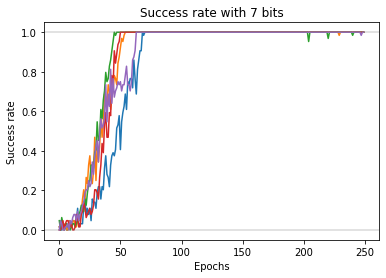

In [139]:
for i in range(len(results)):
    plt.plot(results[i], label='' )

#plt.plot(np.mean(results, axis=0), label='', c='black')

plt.xlabel('Epochs')
plt.ylabel('Success rate')
plt.title('Success rate with {} bits\nHER = "None"'.format(num_bits))
plt.ylim(-0.05, 1.05)
plt.axhline(0, c='gray', alpha=0.3 )
plt.axhline(1, c='gray', alpha=0.3 )
#plt.legend()
plt.show()

In [140]:
x = experiment(HER="final", 
               num_bits=7, 
               num_epochs=250,
               log_interval=50,
               opt_steps=40,
               num_episodes=64)

results = x.run_games(n=5)

Running bit flip environment with 7 bits and HER policy: final
Epoch: 0  Mean reward: -6.516273  Success rate: 0.0000 Mean loss: 4.8766
Epoch: 50  Mean reward: -2.930850  Success rate: 0.4375 Mean loss: 2.7422
Epoch: 100  Mean reward: -1.973752  Success rate: 0.9375 Mean loss: 2.7141
Epoch: 150  Mean reward: -1.356013  Success rate: 1.0000 Mean loss: 2.2749
Epoch: 200  Mean reward: -1.835009  Success rate: 1.0000 Mean loss: 2.1341
Running bit flip environment with 7 bits and HER policy: final
Epoch: 0  Mean reward: -5.458490  Success rate: 0.0156 Mean loss: 4.1286
Epoch: 50  Mean reward: -3.040046  Success rate: 0.2969 Mean loss: 2.8477
Epoch: 100  Mean reward: -3.067343  Success rate: 0.4531 Mean loss: 2.7345
Epoch: 150  Mean reward: -1.604520  Success rate: 0.6562 Mean loss: 2.2470
Epoch: 200  Mean reward: -1.302050  Success rate: 0.9062 Mean loss: 2.0231
Running bit flip environment with 7 bits and HER policy: final
Epoch: 0  Mean reward: -7.326097  Success rate: 0.0156 Mean loss: 4

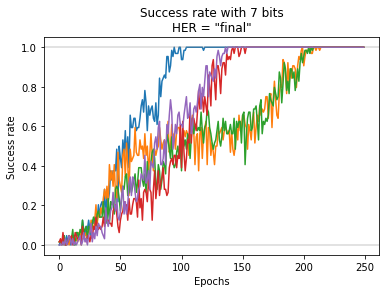

In [141]:

for i in range(len(results)):
    plt.plot(results[i], label='' )

#plt.plot(np.mean(results, axis=0), label='', c='black')

plt.xlabel('Epochs')
plt.ylabel('Success rate')
plt.title('Success rate with {} bits\nHER = "final"'.format(num_bits))
plt.ylim(-0.05, 1.05)
plt.axhline(0, c='gray', alpha=0.3 )
plt.axhline(1, c='gray', alpha=0.3 )
#plt.legend()
plt.show()

b)

In [194]:
num_bits = 15
x = experiment(HER="None", 
               num_bits=num_bits, 
               num_epochs=500,
               log_interval=50,
               opt_steps=40,
               num_episodes=64)

results = x.run_games(n=5)

Running bit flip environment with 8 bits and HER policy: None
Epoch: 0  Mean reward: -6.975331  Success rate: 0.0000 Mean loss: 7.5265
Epoch: 50  Mean reward: -2.702182  Success rate: 0.1406 Mean loss: 0.3189
Epoch: 100  Mean reward: -1.913644  Success rate: 0.9375 Mean loss: 0.8092
Epoch: 150  Mean reward: -1.199809  Success rate: 1.0000 Mean loss: 1.2174
Epoch: 200  Mean reward: -1.942960  Success rate: 1.0000 Mean loss: 0.9492
Epoch: 250  Mean reward: -1.852154  Success rate: 1.0000 Mean loss: 0.7382
Epoch: 300  Mean reward: -1.517837  Success rate: 1.0000 Mean loss: 0.5283
Epoch: 350  Mean reward: -3.190156  Success rate: 1.0000 Mean loss: 0.4171
Epoch: 400  Mean reward: -1.270134  Success rate: 0.9375 Mean loss: 0.3402
Epoch: 450  Mean reward: -2.733894  Success rate: 0.9844 Mean loss: 0.3036
Running bit flip environment with 8 bits and HER policy: None
Epoch: 0  Mean reward: -6.227578  Success rate: 0.0156 Mean loss: 9.3738
Epoch: 50  Mean reward: -5.081169  Success rate: 0.1562 

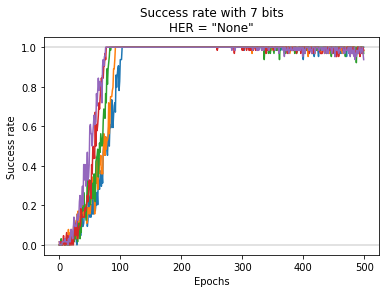

In [195]:
for i in range(len(results)):
    plt.plot(results[i], label='' )

#plt.plot(np.mean(results, axis=0), label='', c='black')

plt.xlabel('Epochs')
plt.ylabel('Success rate')
plt.title('Success rate with {} bits\nHER = "None"'.format(num_bits))
plt.ylim(-0.05, 1.05)
plt.axhline(0, c='gray', alpha=0.3 )
plt.axhline(1, c='gray', alpha=0.3 )
#plt.legend()
plt.show()

In [ ]:
x = experiment(HER="final", 
               num_bits=8, 
               num_epochs=500,
               log_interval=50,
               opt_steps=40,
               num_episodes=64)

results = x.run_games(n=5)

In [ ]:
for i in range(len(results)):
    plt.plot(results[i], label='' )

#plt.plot(np.mean(results, axis=0), label='', c='black')

plt.xlabel('Epochs')
plt.ylabel('Success rate')
plt.title('Success rate with {} bits\nHER = "final"'.format(num_bits))
plt.ylim(-0.05, 1.05)
plt.axhline(0, c='gray', alpha=0.3 )
plt.axhline(1, c='gray', alpha=0.3 )
#plt.legend()
plt.show()